# SVM

利用`超平面`将样本分类.

### 推导过程

定义`超平面`: 
$$
f(x) = W^Tx + b
$$

令:
$$
\begin{cases}
W^Tx_i + b \geq +1 & y_i = +1 \\
W^Tx_i + b \leq -1 & y_i = -1 \\
\end{cases}
$$

> y 的分类取值 {-1, 1} 而并非逻辑回归中的 {0, 1}, 是为了方便统一计算 $y_i(W^Tx_i + b) \geq 1$

则这 2 个`超平面`的间距为:
$$
d = \frac{2}{||W||}
$$

SVM 问题转为求 $\max d = \max \frac{2}{||W||}$

或求 $\min ||W||$ 加个 $\frac12$, 便于后续求导运算.
即求 $\min \frac12||W||^2$

即:
$$
\begin{align*}
\min \quad & \frac12w^Tw \\
\text{s.t.} \quad & y_i(wx_i + b) \geq 1 \\
\end{align*}
$$

转换约束条件,得:
$$
\begin{align*}
\min \quad & \frac12w^Tw \\
\text{s.t.} \quad & 1 - y_i(wx_i + b) \leq 0 \\
\end{align*}
$$

该问题即可使用 `拉格朗日乘子法` 解决:

$$
\begin{align*}
\min_{w, b}\max_{\alpha}\mathcal{L}(w, b, \alpha) & = \frac12w^Tw + \sum_i^N\alpha_ig_i(x) \\
 & = \frac12w^Tw + \sum_i^N\alpha_i(1 - y_i(wx_i + b)) \\
 & = \frac12w^Tw - \sum_i^N\alpha_iy_i(wx_i + b) + \sum_i^N\alpha_i \\
\end{align*}
$$

对 $w, b$ 取导为 0 ,得:
$$
\begin{align*}
\frac{\partial\mathcal{L}(w, b, \alpha)}{\partial w} & = w - \sum_i^N\alpha_iy_ix_i = 0  \\
\frac{\partial\mathcal{L}(w, b, \alpha)}{\partial b} & = -\sum_i^N\alpha_iy_i = 0 \\
\end{align*}
$$

即:
$$
w = \sum_i^N\alpha_iy_ix_i \\
\sum_i^N\alpha_iy_i = 0 \\
$$

将以上 2 式带入 $\mathcal{L}(w, b, \alpha)$, 得:
$$
\begin{align*}
\min_{w, b}\max_{\alpha}\mathcal{L}(w, b, \alpha) & = \frac12(\sum_i^N\alpha_iy_ix_i)^T(\sum_j^N\alpha_jy_jx_j) - \sum_i^N\alpha_iy_i(\sum_j^N\alpha_jy_jx_j)x_i + b) + \sum_i^N\alpha_i \\
& = \frac12\sum_{i, j=1}^N\alpha_iy_i\alpha_jy_jx_i^Tx_j - \sum_{i, j=1}^N\alpha_iy_i\alpha_jy_jx_i^Tx_j - b\sum_i^N\alpha_iy_i + \sum_i^N\alpha_i\\
& = -\frac12\sum_{i, j=1}^N\alpha_iy_i\alpha_jy_jx_i^Tx_j + \sum_i^N\alpha_i\\
\end{align*}
$$

即最终问题:
$$
\begin{align*}
\max_\alpha W(\alpha) & = -\frac12\sum_{i, j=1}^N\alpha_iy_i\alpha_jy_jx_i^Tx_j + \sum_i^N\alpha_i \\
\text{s.t.} \quad & \sum_i^N\alpha_iy_i = 0 \\
& \alpha_i \geq 0 \\
\end{align*}
$$

KTT:
$$
\begin{cases}
\alpha_i \geq 0 \\
1 - y_i(w^Tx_i + b) \leq 0 \\
\alpha_i(1 - y_i(w^Tx_i + b) = 0
\end{cases}
$$

### 生成学习数据

In [1]:
import numpy as np

def generate_data(num, w, b):
    x_1 = np.linspace(0, 10, num)
    x_2 = x_1 * w + b
    d = np.hstack((np.random.uniform(5, 50, size = num // 2), np.random.uniform(-50, -5, size = num // 2)))
    np.random.shuffle(d)
    x_2 += d
    return np.c_[x_1, x_2], np.sign(d)

### 求解 $\alpha_i$ : SMO 算法

1. 随机选取 2 个 $\alpha_1, \alpha_2$
2. 确定 $\alpha_2^{new}$ 上下限 L, H:
  $$
  \begin{cases}
  L = \max(0, \alpha_2^{old} - \alpha_1^{old}), H = min(C, C + \alpha_2^{old} - \alpha_1^{old}) & \text{if}\;y_1 \neq y_2 \\ 
  L = \max(C, \alpha_2^{old} + \alpha_1^{old} - C), H = min(C, \alpha_2^{old} + \alpha_1^{old}) & \text{if}\;y_1 = y_2 \\ 
  \end{cases}
  $$
3. 根据以下公式更新 $\alpha_2$:
  ```
  # K 为內积
  K = lambda x1, x2: x1 @ x2.T
  ```
  $$
  E_i = \hat y_i - y_i \\
  \eta = 2K(x_1, x_2) - K(x_1, x_1) - K(x_2, x_2) \\
  \alpha_2^{new} = \alpha_2^{old} - \frac{y_2(E_1 - E_2)}{\eta} \\
  L \leq \alpha_2^{new} \leq H
  $$
4. 根据以下公式更新 $\alpha_1$:
  $$
  \alpha_1^{new} = \alpha_1^{old} + y_1y_2(\alpha_2^{old} - \alpha_2^{new})
  $$
5. 更新 b:
  $$
  b_1 = b^{old} - E_1 - y_1(\alpha_1^{new} - \alpha_1^{old})K(x_1, x_1) - y_2(\alpha_2^{new} - \alpha_2^{old})K(x_1, x_2)\\
  b_2 = b^{old} - E_2 - y_1(\alpha_1^{new} - \alpha_1^{old})K(x_1, x_2) - y_2(\alpha_2^{new} - \alpha_2^{old})K(x_2, x_2)\\
  b = \begin{cases}
  b_1 & \text{if}\quad 0 \leq \alpha_1^{new} \leq C \\
  b_2 & \text{if}\quad 0 \leq \alpha_2^{new} \leq C \\
  \frac{b_1 + b_2}{2} & \text{otherwise} \\
  \end{cases}
  $$

### 定义[RBFKernel](./kernels.ipynb#Radial-basis-%E6%A0%B8%E5%87%BD%E6%95%B0)

In [2]:
def pairwise_l2_distances(X, Y):
    D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
    D[D < 0] = 0  # clip any value less than 0 (a result of numerical imprecision)
    return np.sqrt(D)

def RBF_kernel(x, y, sigma = 0.1):
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    return np.exp(- sigma * pairwise_l2_distances(x, y) ** 2).flatten()

### 分离训练集和测试集

In [3]:
def train_test_split(x, y, split_size = 0.7):
    m = len(x)
    shuffle_idx = np.random.permutation(np.arange(m))
    train_size = int(m * split_size)
    x_train = x[shuffle_idx[:train_size]]
    y_train = y[shuffle_idx[:train_size]]
    x_test = x[shuffle_idx[train_size:]]
    y_test = y[shuffle_idx[train_size:]]
    
    return x_train, y_train, x_test, y_test

In [4]:
class SVM():
    def __init__(self,trainX,trainY, C=1, difference=1e-3, max_iter=100):
        self.C = C  #正则化的参数
        self.difference = difference #用来判断是否收敛的阈值
        self.max_iter = max_iter #迭代次数的最大值

        self.b = 0 # 偏置值
        self.K = None # 特征经过核函数转化的值
        self.X = trainX
        self.Y = trainY
        self.m = trainX.shape[0]
        self.n = trainX.shape[1]
        self.K = np.zeros((self.m, self.m)) #核的新特征数组初始化

        for i in range(self.m):
            self.K[:, i] = RBF_kernel(self.X, self.X[i, :]) #每一行数据的特征通过核函数转化 n->m

        self.alpha = np.zeros(self.m) #拉格朗日乘子初始化


    def train(self):

        for now_iter in range(self.max_iter):

            alpha_prev = np.copy(self.alpha)
            for j in range(self.m):

                #选择第二个优化的拉格朗日乘子
                i = self.random_index(j)
                error_i, error_j = self.error_row(i), self.error_row(j)

                #检验他们是否满足KKT条件，然后选择违反KKT条件最严重的self.alpha[j]
                if (self.Y[j] * error_j < -0.001 and self.alpha[j] < self.C) or (self.Y[j] * error_j > 0.001 and self.alpha[j] > 0):

                    eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]  #第j个要优化的拉格朗日乘子，最后需要的

                    if eta >= 0:
                        continue

                    L, H = self.getBounds(i, j)
                    old_alpha_j, old_alpha_i = self.alpha[j], self.alpha[i]  #旧的拉格朗日乘子的值
                    self.alpha[j] -= (self.Y[j] * (error_i - error_j)) / eta  #self.alpha[j]的更新

                    #根据约束最后更新拉格朗日乘子self.alpha[j]，并且更新self.alpha[j]
                    self.alpha[j] = self.finalValue(self.alpha[j], H, L)
                    self.alpha[i] = self.alpha[i] + self.Y[i] * self.Y[j] * (old_alpha_j - self.alpha[j])

                    #更新偏置值b
                    b1 = self.b - error_i - self.Y[i] * (self.alpha[i] - old_alpha_i) * self.K[i, i] - \
                         self.Y[j] * (self.alpha[j] - old_alpha_j) * self.K[i, j]
                    b2 = self.b - error_j - self.Y[j] * (self.alpha[j] - old_alpha_j) * self.K[j, j] - \
                         self.Y[i] * (self.alpha[i] - old_alpha_i) * self.K[i, j]
                    if 0 < self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = 0.5 * (b1 + b2)

            #判断是否收敛
            diff = np.linalg.norm(self.alpha - alpha_prev)
            if diff < self.difference:
                break


    #随机一个要优化的拉格朗日乘子，该乘子必须和循环里面选择的乘子不同
    def random_index(self, first_alpha):
        i = first_alpha
        while i == first_alpha:
          i = np.random.randint(0, self.m - 1)
        return i

    #用带拉格朗日乘子表示的w代入wx+b
    def predict_row(self, X):
        k_v = RBF_kernel(self.X, X)

        return np.dot((self.alpha * self.Y).T, k_v.T) + self.b

    #预测，返回一个判断正确的index的矩阵
    def predict(self, X):
        n = X.shape[0]
        result = np.zeros(n)
        for i in range(n):
            result[i] = np.sign(self.predict_row(X[i, :])) #正的返回1，负的返回-1
        return result

    #预测的值减真实的Y
    def error_row(self, i):

        return self.predict_row(self.X[i]) - self.Y[i]

    #得到self.alpha[j]的范围约束
    def getBounds(self,i,j):

        if self.Y[i] != self.Y[j]:
            L = max(0, self.alpha[j] - self.alpha[i])
            H = min(self.C, self.C - self.alpha[i] + self.alpha[j])
        else:
            L = max(0, self.alpha[i] + self.alpha[j] - self.C)
            H = min(self.C, self.alpha[i] + self.alpha[j])
        return L, H


    #根据self.alpha[i]的范围约束获得最终的值
    def finalValue(self,alpha,H,L):

        if alpha > H:
            alpha = H
        elif alpha < L:
            alpha = L

        return alpha

In [5]:
#返回准确率
def accuracy(actual, predicted):
    return 1.0 - sum(actual != predicted) / float(actual.shape[0])

In [6]:
import matplotlib.pyplot as plt

def plot_in_2d(X, y=None, title=None, accuracy=None, legend_labels=None):
    cmap = plt.get_cmap('viridis')

    x1 = X[:, 0]
    x2 = X[:, 1]
    class_distr = []
    y = np.array(y).astype(int)

    colors = [cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

    # Plot the different class distributions
    for i, l in enumerate(np.unique(y)):
        _x1 = x1[y == l]
        _x2 = x2[y == l]
        _y = y[y == l]
        class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

    # Plot legend
    if not legend_labels is None:
        plt.legend(class_distr, legend_labels, loc=1)

    # Plot title
    if title:
        if accuracy:
            perc = 100 * accuracy
            plt.suptitle(title)
            plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
        else:
            plt.title(title)

    # Axis labels
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.show()

In [7]:
def run():
    X, y = generate_data(1200, 3, 0)
    X_train, y_train, X_test, y_test = train_test_split(X, y, split_size=0.8)

    model = SVM(X_train,y_train,max_iter=100, C=0.6)
    model.train()

    predictions = model.predict(X_test)
    
    accuracyRate = accuracy(y_test, predictions)

    print('Classification accuracy %s'
          % (accuracyRate))
    
    plot_in_2d(X_test, predictions, title="Support Vector Machine", accuracy=accuracyRate)


Classification accuracy 1.0


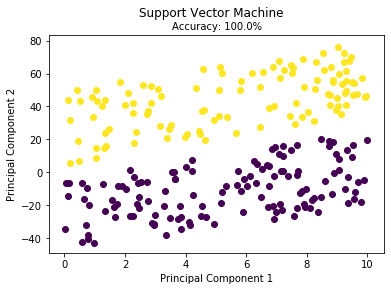

In [8]:
run()